## Scalable Angular Spectrum Method

<a target="_blank" href="https://colab.research.google.com/github/chromatix-team/chromatix/blob/main/docs/examples/sas.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

License
If you copy this code, include this LICENSE statement:

MIT License. Copyright (c) 2023 Felix Wechsler (info@felixwechsler.science), Rainer Heintzmann, Lars Lötgering

This notebook is based on https://github.com/bionanoimaging/Scalable-Angular-Spectrum-Method-SAS/blob/main/SAS_pytorch.ipynb

In [1]:
from colorsys import hls_to_rgb

import jax as jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.numpy import pi

import chromatix.functional as cx

In [2]:
# CC nadapez: from https://stackoverflow.com/a/20958684
def colorize(z):
    r = np.abs(z)
    arg = np.angle(z)

    hue = (arg + pi) / (2 * pi) + 0.5
    lightness = 1.0 - 1.0 / (1.0 + r**0.3)
    saturation = 0.8

    c = np.vectorize(hls_to_rgb)(hue, lightness, saturation)  # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0, 2)
    c = c.swapaxes(0, 1)
    return c

In [3]:
N_box = 512
L_box = 128  # µm
lbd = 0.5
shape = (N_box, N_box)
kx = 2 * jnp.pi / lbd * np.sin(20 / 360 * 2 * jnp.pi)
field = (
    cx.plane_wave(
        shape=shape, dx=L_box / N_box, spectrum=lbd, spectral_density=1.0, kykx=[0, kx]
    )
    / 0.0078125
)

D_box = L_box / 16
field = cx.square_pupil(field, w=D_box)

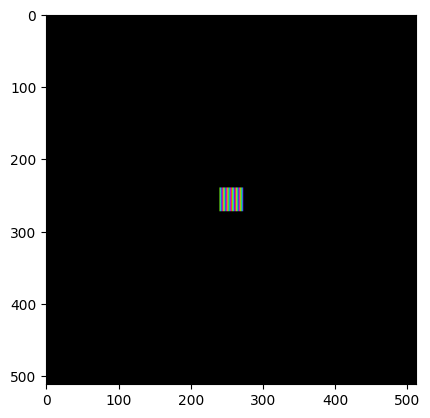

In [4]:
plt.imshow(colorize(field.u[0, :, :, 0, 0]))
plt.show()

### SAS (Scalable Angular Spectrum)

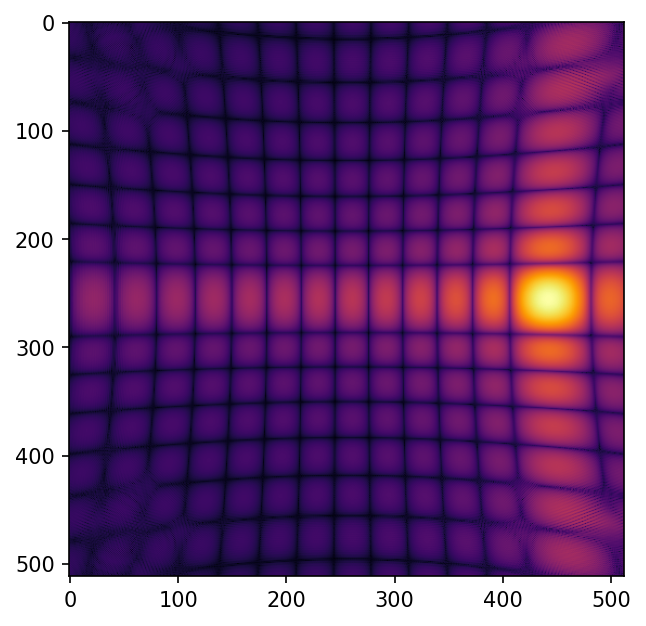

In [5]:
M_box = 8
z_box = M_box / N_box / lbd * L_box**2 * 2
field_p = jax.jit(cx.propagation.transform_propagate_sas)(field, z=z_box, n=1.0)

fig = plt.figure(dpi=150)
plt.imshow(((field_p.intensity.squeeze()) ** 0.13), cmap="inferno")
plt.show()

### Fresnel transform propagation (single Fourier transform) is inaccurate

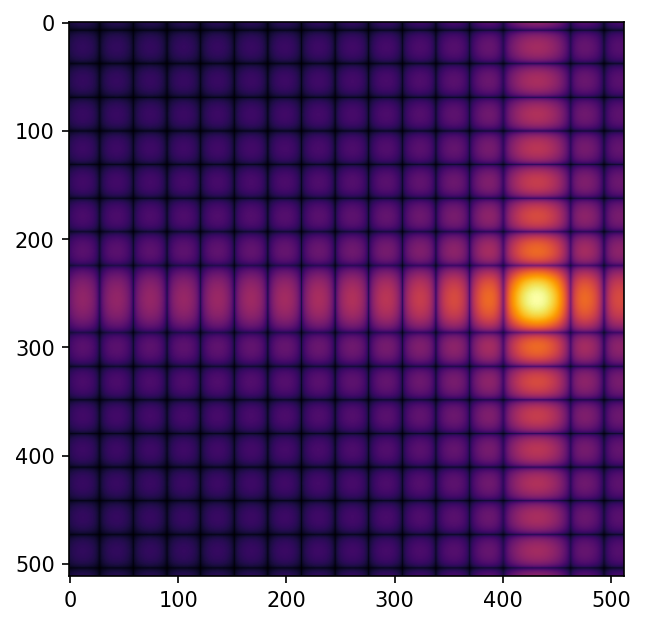

In [6]:
z_box = M_box / N_box / lbd * L_box**2 * 2
field_p = jax.jit(cx.propagation.transform_propagate, static_argnums=3)(
    field, z=z_box, n=1.0, N_pad=256
)

fig = plt.figure(dpi=150)
plt.imshow(((field_p.intensity.squeeze()) ** 0.13), cmap="inferno")
plt.show()

### ASM (Angular Spectrum Method) requires excessive padding

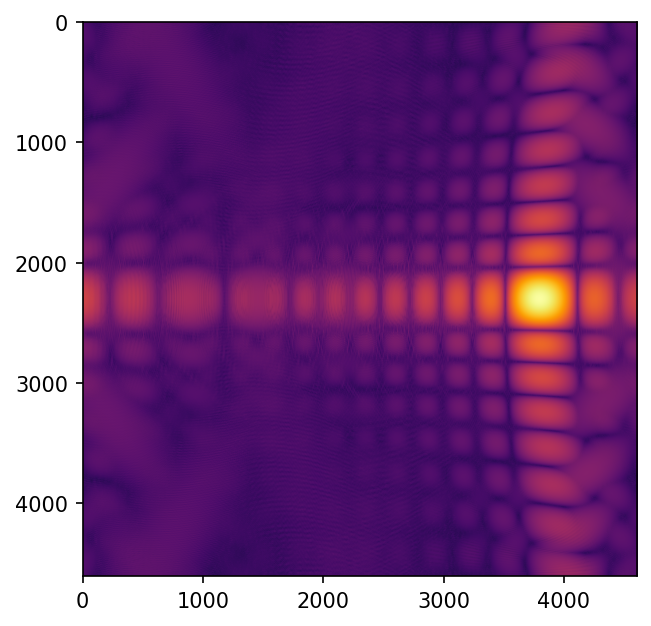

In [7]:
z_box = M_box / N_box / lbd * L_box**2 * 2
field_p = jax.jit(cx.propagation.asm_propagate, static_argnames=("N_pad", "mode"))(
    field, z=z_box, n=1.0, N_pad=2048, mode="full"
)

fig = plt.figure(dpi=150)
plt.imshow(((field_p.intensity.squeeze()) ** 0.13), cmap="inferno")
plt.show()